<a href="https://colab.research.google.com/github/vedvkandge2000/Deep-Learning-Project/blob/master/Transfer_Learning_Using_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [ ]:
# Here we start with data augmentation and normalization for training
# Data augmentation means just creating images from different images by croping it, fliping it etc.
# Data augmentation is one of the technique to reduce the overfitting.
# https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d (Data augmentation)
# https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Load the data from drive.
data_dir = "/content/drive/My Drive/hymenoptera_data"
# Create a dictionary of datasets contains information about dataset.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train","val"]}
# Creating a dictionary that contains a dataloader.
dataloaders = {x:  torch.utils.data.DataLoader(image_datasets[x],
                                               batch_size=4,
                                               shuffle=True) for x in ["train","val"]}
# Creating the dictionary that contains the size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ["train","val"]}
# Get the names of classes
class_names = image_datasets["train"].classes
#Print out the results 
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [ ]:
# Load the ResNet Network 
model_conv = torchvision.models.resnet18(pretrained=True)

In [ ]:
# Freeze all the weigths and layers in network because we do not want to train all layer we only want to change the last layers
# model_conv.parametera will get the all weights and parameters so we want to freeze all weights
for param in model_conv.parameters():
  param.requires_grad = False

In [ ]:
# Now we want to replace teh final fc layes of cnn with our cnn
# So now we want number of inputs of last layer( number neurons in layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
# Reconstruct the last layer because we want only two output classes while original fc layer have 1000 output classes.
model_conv.fc = nn.Linear(num_ftrs,2)

In [ ]:
if torch.cuda.is_available():
  model_conv = model_conv.cuda()

In [ ]:
# Deeper understanding of what is happing during training
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([0, 0, 1, 1], device='cuda:0')
Output Tensor: tensor([[-0.1042, -0.4044],
        [ 0.2645,  0.0825],
        [-0.3671, -0.5433],
        [-0.7004,  0.3804]], device='cuda:0', grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 1], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(3, device='cuda:0')


In [ ]:
# Loss function and other
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv.fc.parameters(),lr=0.001) #optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
# optim.Adam(model_conv.fc.parameters(),lr=0.001)
# Decay lr by a factor of 0.1 for every 7 epochs
exp_lr_schedular = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)


In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
  correct = 0
  for images, labels in dataloaders["train"]:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model_conv(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum().item()
  exp_lr_schedular.step()
  train_acc = 100 * correct / dataset_sizes["train"]
  print("Epoch [{}/{}], Loss: {:.4f}, Train_Accuracy: {}%".format(epoch+1,num_epochs,loss.item(), train_acc))


Epoch [1/30], Loss: 0.4096, Train_Accuracy: 67.21311475409836%
Epoch [2/30], Loss: 0.2356, Train_Accuracy: 82.78688524590164%
Epoch [3/30], Loss: 0.1320, Train_Accuracy: 79.91803278688525%
Epoch [4/30], Loss: 0.3900, Train_Accuracy: 82.78688524590164%
Epoch [5/30], Loss: 0.4509, Train_Accuracy: 81.9672131147541%
Epoch [6/30], Loss: 0.2680, Train_Accuracy: 85.24590163934427%
Epoch [7/30], Loss: 0.0375, Train_Accuracy: 77.8688524590164%
Epoch [8/30], Loss: 0.4184, Train_Accuracy: 83.19672131147541%
Epoch [9/30], Loss: 0.0516, Train_Accuracy: 81.14754098360656%
Epoch [10/30], Loss: 0.4411, Train_Accuracy: 86.47540983606558%
Epoch [11/30], Loss: 0.1911, Train_Accuracy: 87.29508196721312%
Epoch [12/30], Loss: 0.1010, Train_Accuracy: 81.55737704918033%
Epoch [13/30], Loss: 0.2298, Train_Accuracy: 85.24590163934427%
Epoch [14/30], Loss: 0.2637, Train_Accuracy: 84.8360655737705%
Epoch [15/30], Loss: 0.6385, Train_Accuracy: 84.8360655737705%
Epoch [16/30], Loss: 0.0764, Train_Accuracy: 81.55737

In [ ]:
# Test teh model
model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders["val"]:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 94.118 %


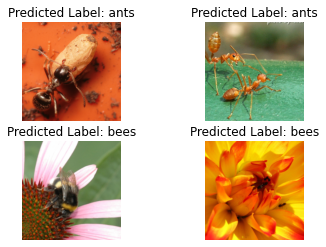

In [ ]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)